In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_pie_chart(counter, title):
    labels = counter.keys()
    sizes = counter.values()

    plt.figure()  # 创建新的图形
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # 确保饼图是圆的
    plt.title(title)

In [3]:
import os

os.environ["all_proxy"] = "http://127.0.0.1:10808"

import importlib
importlib.reload(os)

<module 'os' from '/usr/lib/python3.10/os.py'>

In [4]:
import json

from datasets import load_dataset


ds = load_dataset("/home/llm/.cache/huggingface/datasets/princeton-nlp___swe-bench_lite")
ds

/home/llm/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 1472 examples [00:00, 25988.52 examples/s]
Generating test split: 19200 examples [00:00, 58833.71 examples/s]


DatasetDict({
    validation: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 1472
    })
    test: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 19200
    })
})

# Count the issue with images


- instance_id: A formatted instance identifier, usually as repo_owner__repo_name-PR-number.
- base_commit: The commit hash of the repository representing the HEAD of the repository BEFORE the solution PR is applied.
- patch: The gold patch, the patch generated by the PR (exclude the test-related code), that resolved the issue.
- test_patch: A test-file patch that was contributed by the solution PR.
- problem_statement: The issue (correspond the PR) title and body
- hints_text: Comments of target issue
- created_at: Creation time of the PR
- version: Installation version to use for running evaluation.
- FAIL_TO_PASS: A list (json array) of strings that represent the tests resolved by the PR and tied to the issue resolution. (new tests added in the solution PR)
- PASS_TO_PASS: A json list of strings that represent tests that should pass before and after the PR application.
- environment_setup_commit: commit hash to use for environment setup and installation. (the commit hash of next release version (with the PR and ensure it can be executed))

In [8]:
ds['test'][90]

{'repo': 'django/django',
 'instance_id': 'django__django-15347',
 'base_commit': '7c4f3965098baad2396e24501e09237425a7bd6f',
 'patch': 'diff --git a/django/contrib/messages/storage/cookie.py b/django/contrib/messages/storage/cookie.py\n--- a/django/contrib/messages/storage/cookie.py\n+++ b/django/contrib/messages/storage/cookie.py\n@@ -19,7 +19,7 @@ def default(self, obj):\n             # Using 0/1 here instead of False/True to produce more compact json\n             is_safedata = 1 if isinstance(obj.message, SafeData) else 0\n             message = [self.message_key, is_safedata, obj.level, obj.message]\n-            if obj.extra_tags:\n+            if obj.extra_tags is not None:\n                 message.append(obj.extra_tags)\n             return message\n         return super().default(obj)\n',
 'test_patch': 'diff --git a/tests/messages_tests/test_cookie.py b/tests/messages_tests/test_cookie.py\n--- a/tests/messages_tests/test_cookie.py\n+++ b/tests/messages_tests/test_cookie.py\

In [10]:
s = 'Messages framework incorrectly serializes/deserializes extra_tags when it\'s an empty string\nDescription\n\t\nWhen a message is serialised and then deserialised with any of the built in storage backends, then extra_tags=="" is converted to extra_tags==None. This is because MessageEncoder checks for the truthyness of extra_tags rather than checking it is not None.\nTo replicate this bug\n>>> from django.conf import settings\n>>> settings.configure() # Just to allow the following import\n>>> from django.contrib.messages.storage.base import Message\n>>> from django.contrib.messages.storage.cookie import MessageEncoder, MessageDecoder\n>>> original_message = Message(10, "Here is a message", extra_tags="")\n>>> encoded_message = MessageEncoder().encode(original_message)\n>>> decoded_message = MessageDecoder().decode(encoded_message)\n>>> original_message.extra_tags == ""\nTrue\n>>> decoded_message.extra_tags is None\nTrue\nEffect of the bug in application behaviour\nThis error occurred in the wild with a template tag similar to the following:\n{% if x not in message.extra_tags %}\nWhen the message was displayed as part of a redirect, it had been serialised and deserialized which meant that extra_tags was None instead of the empty string. This caused an error.\nIt\'s important to note that this bug affects all of the standard API (messages.debug, messages.info etc. all have a default value of extra_tags equal to "").\n'
print(s)

Messages framework incorrectly serializes/deserializes extra_tags when it's an empty string
Description
	
When a message is serialised and then deserialised with any of the built in storage backends, then extra_tags=="" is converted to extra_tags==None. This is because MessageEncoder checks for the truthyness of extra_tags rather than checking it is not None.
To replicate this bug
>>> from django.conf import settings
>>> settings.configure() # Just to allow the following import
>>> from django.contrib.messages.storage.base import Message
>>> from django.contrib.messages.storage.cookie import MessageEncoder, MessageDecoder
>>> original_message = Message(10, "Here is a message", extra_tags="")
>>> encoded_message = MessageEncoder().encode(original_message)
>>> decoded_message = MessageDecoder().decode(encoded_message)
>>> original_message.extra_tags == ""
True
>>> decoded_message.extra_tags is None
True
Effect of the bug in application behaviour
This error occurred in the wild with a tem

In [81]:
import re
imgUrlPattern = re.compile(r'!\[image\]\((https?:\/\/[^\s]+)\)')

def contains_img_url(s: str, output_img_url=False) -> bool:
    matches = imgUrlPattern.findall(s)
    if matches:
        if output_img_url:
            for match in matches:
                print(match)
        return True
    return False


def count_imgs_in_cols(target_ds, cols=['problem_statement', 'hints_text']):
    ret = 0
    for i, dct in enumerate(target_ds):
        for col_name in cols:
            if contains_img_url(dct[col_name]):
                ret += 1
                break
    return ret

cnt_img_dev = count_imgs_in_cols(ds['dev'])
cnt_img_test = count_imgs_in_cols(ds['test'])
print("instance with img in data['dev']: ", cnt_img_dev)
print("instance with img in data['test']: ", cnt_img_test)

# ratio of img:
print(f"ratio of image in data['dev']: {cnt_img_dev / len(ds['dev']):.2%}")
print(f"ratio of image in data['test']: {cnt_img_test / len(ds['test']):.2%}")

instance with img in data['dev']:  0
instance with img in data['test']:  2
ratio of image in data['dev']: 0.00%
ratio of image in data['test']: 0.67%


# Describe the install versions of SWE-bench lite

> PS: same answer compared to "describe the environment_setup_commit of SWE-bench lite"

In [54]:
def describe_install_versions(target_ds):
    stat_dct = dict()
    for dct in target_ds:
        install_version = dct['repo'] + '-' + dct['version']
        if install_version not in stat_dct:
            stat_dct[install_version] = 1
        else:
            stat_dct[install_version] += 1
    sorted_stat_dct = dict(sorted(stat_dct.items()))
    for key, value in sorted_stat_dct.items():
        print(f"{key}: {value}")
    print(f'count of versions: {len(sorted_stat_dct)}')

print("describe the versions in  data['dev']:\n")
describe_install_versions(ds['dev'])
print("\n\n\ndescribe the versions in data['test']:\n")
describe_install_versions(ds['test'])

describe the versions in  data['dev']:

marshmallow-code/marshmallow-2.20: 1
marshmallow-code/marshmallow-3.0: 1
pvlib/pvlib-python-0.7: 1
pvlib/pvlib-python-0.8: 2
pvlib/pvlib-python-0.9: 2
pydicom/pydicom-1.3: 1
pydicom/pydicom-2.0: 1
pydicom/pydicom-2.1: 2
pydicom/pydicom-2.3: 1
pylint-dev/astroid-2.10: 1
pylint-dev/astroid-2.12: 1
pylint-dev/astroid-2.13: 1
pylint-dev/astroid-2.14: 1
pylint-dev/astroid-2.9: 1
pyvista/pyvista-0.39: 1
sqlfluff/sqlfluff-0.6: 4
sqlfluff/sqlfluff-0.8: 1
count of versions: 17



describe the versions in data['test']:

astropy/astropy-1.3: 2
astropy/astropy-4.3: 1
astropy/astropy-5.1: 2
astropy/astropy-5.2: 1
django/django-3.0: 15
django/django-3.1: 21
django/django-3.2: 20
django/django-4.0: 19
django/django-4.1: 14
django/django-4.2: 16
django/django-5.0: 9
matplotlib/matplotlib-3.3: 1
matplotlib/matplotlib-3.5: 7
matplotlib/matplotlib-3.6: 8
matplotlib/matplotlib-3.7: 7
mwaskom/seaborn-0.12: 3
mwaskom/seaborn-0.13: 1
pallets/flask-2.0: 1
pallets/flask-



So, the docker images we should prepared: 
- 17 docker images in dev stage,  
- 64 docker images in test (submission) stages

# Describe the repositories of SWE-bench lite

describe the data['dev']:

marshmallow-code/marshmallow: 2
pvlib/pvlib-python: 5
pydicom/pydicom: 5
pylint-dev/astroid: 5
pyvista/pyvista: 1
sqlfluff/sqlfluff: 5



describe the data['test']:

astropy/astropy: 6
django/django: 114
matplotlib/matplotlib: 23
mwaskom/seaborn: 4
pallets/flask: 3
psf/requests: 6
pydata/xarray: 5
pylint-dev/pylint: 6
pytest-dev/pytest: 17
scikit-learn/scikit-learn: 23
sphinx-doc/sphinx: 16
sympy/sympy: 77


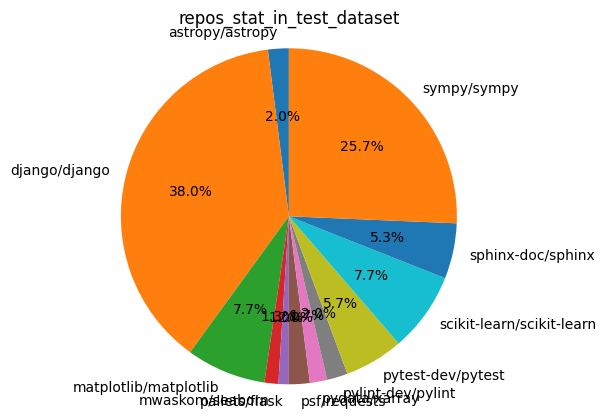

In [57]:
def describe_repositories(target_ds, plot=False, plot_title=''):
    stat_dct = dict()
    
    for dct in target_ds:
        repo = dct['repo']
        if repo not in stat_dct:
            stat_dct[repo] = 1
        else:
            stat_dct[repo] += 1
    sorted_stat_dct = dict(sorted(stat_dct.items()))
    for key, value in sorted_stat_dct.items():
        print(f"{key}: {value}")
    if plot:
        plot_pie_chart(sorted_stat_dct, plot_title)


print("describe the data['dev']:\n")
describe_repositories(ds['dev'])
print("\n\n\ndescribe the data['test']:\n")
describe_repositories(ds['test'], True, 'repos_stat_in_test_dataset')

<div align='left'>
    <img width=30% src="./imgs/lite-repo-stat.png" />
</div>


From the stat and pie-chart, we can know the top repositories:  


django/django: 114  
sympy/sympy: 77  
matplotlib/matplotlib: 23  
scikit-learn/scikit-learn:  23


# Describe the git-patches of SWE-bench lite

In [79]:
from collections import Counter

def count_modified_python_files(patch_str: str) -> int:
    pattern = re.compile(r'diff --git .+\.py .+\.py', re.MULTILINE)
    matches = pattern.findall(patch_str)
    return len(matches)

def plot_histogram(data, title="Frequency Distribution Histogram", xlabel="Value", ylabel="Frequency"):
    """
    绘制频数分布直方图
    :param data: 数据列表
    :param bins: 直方图的柱数
    :param title: 图表标题
    :param xlabel: x轴标签
    :param ylabel: y轴标签
    """
    from collections import Counter
    
    # 使用 Counter 进行频数统计
    counter = Counter(data)
    
    # 提取数据
    labels = list(counter.keys())
    frequencies = list(counter.values())
    
    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.bar(labels, frequencies, tick_label=labels, width=0.6, color='skyblue')
    
    # 添加标题和标签
    plt.title('Frequency Distribution')
    plt.xlabel('Integer')
    plt.ylabel('Frequency')
    plt.grid(True)  # 添加网格线

def describe_patches_contains_py(target_ds, plot=False, plot_title=''):
    max_modified_python_files_cnt = 1
    
    for dct in target_ds:
        patch = dct['patch']
        
        modified_python_files_cnt = count_modified_python_files(patch)
        max_modified_python_files_cnt = max(max_modified_python_files_cnt, modified_python_files_cnt)

    print(f'max_modified_python_files_cnt: {max_modified_python_files_cnt}')



def count_modified_files(patch_str: str):
    # 使用正则表达式匹配以 'diff --git' 开头的行
    pattern = re.compile(r'^diff --git a/.+ b/(.+)', re.MULTILINE)
    matches = pattern.findall(patch_str)
    
    # 创建计数器
    file_counter = Counter()
    
    # 统计每种类型文件的修改次数
    for match in matches:
        file_extension = match.split('.')[-1] if '.' in match else 'no_extension'
        file_counter[file_extension] += 1
    
    # 返回Python文件的修改次数和其他文件的统计信息
    return dict(file_counter)

def describe_patch_files(target_ds):
    file_counter = Counter()
    
    for dct in target_ds:
        patch = dct['patch']
        modified_files_dct = count_modified_files(patch)
        key = str(modified_files_dct)
        file_counter[key] += 1
    print(file_counter)

print("describe the modified python files in data['dev']:\n")
describe_patches_contains_py(ds['dev'])
print("describe the modified files in data['dev']:\n")
describe_patch_files(ds['dev'])

print("\n\n\ndescribe the modified python files in data['test']:\n")
describe_patches_contains_py(ds['test'])
print("describe the modified files in data['test']:\n")
describe_patch_files(ds['test'])

describe the modified python files in data['dev']:

max_modified_python_files_cnt: 1
describe the modified files in data['dev']:

Counter({"{'py': 1}": 23})



describe the modified python files in data['test']:

max_modified_python_files_cnt: 1
describe the modified files in data['test']:

Counter({"{'py': 1}": 300})


</br>
</br>

From the patch files, we can know that EVERY issue can be solved by modifying a single python file

# Describe the token cost of patch(output) / problem_statement(input)

> the token cost of image-understanding is not contains in the stat

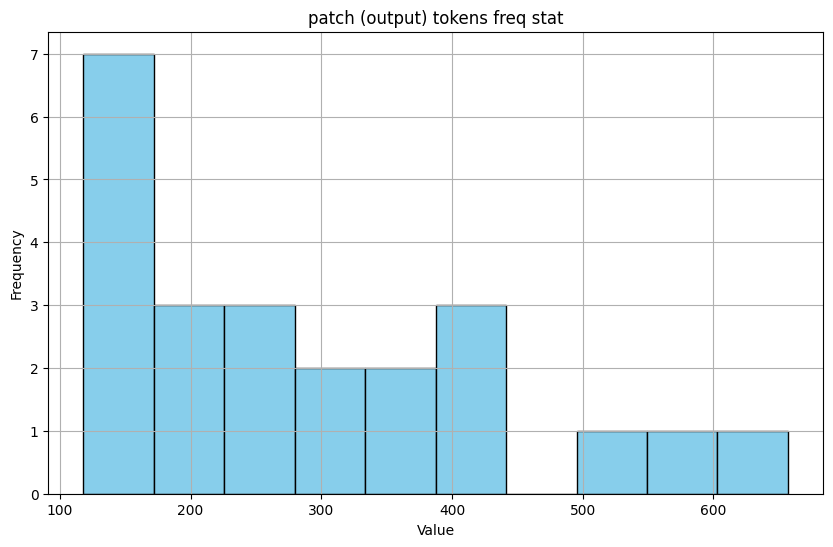

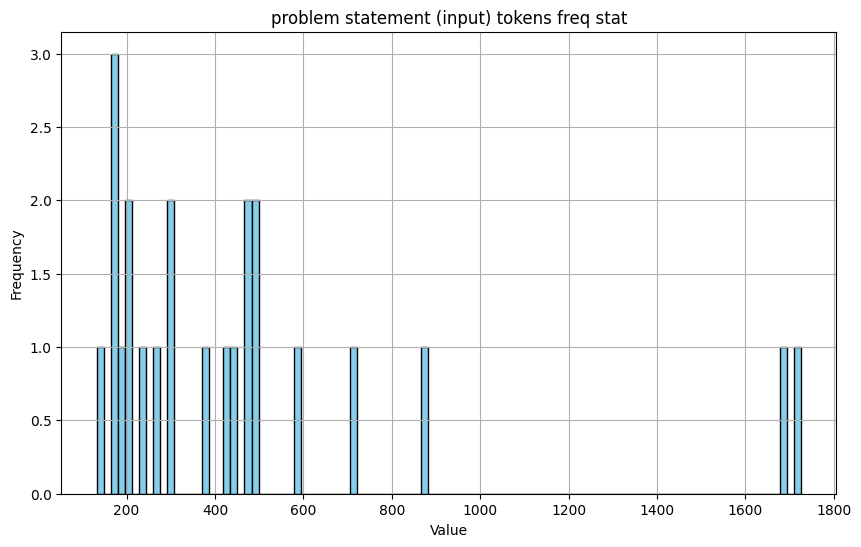

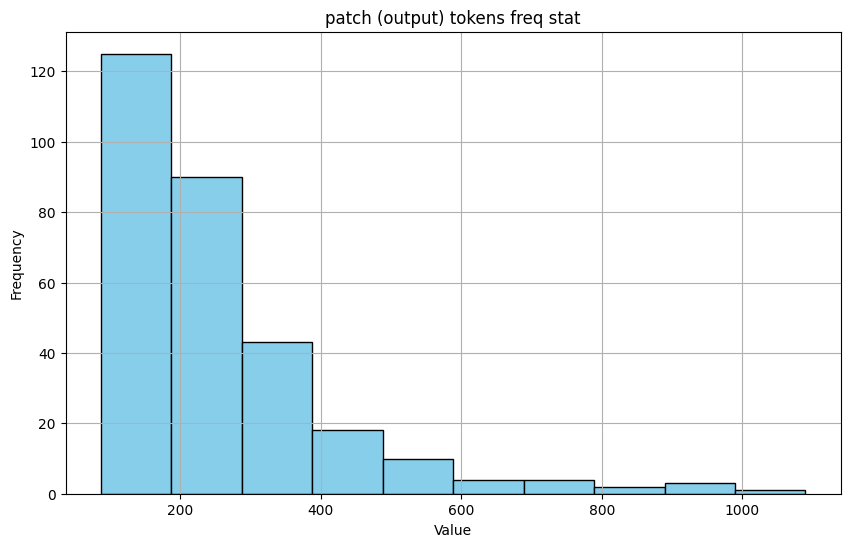

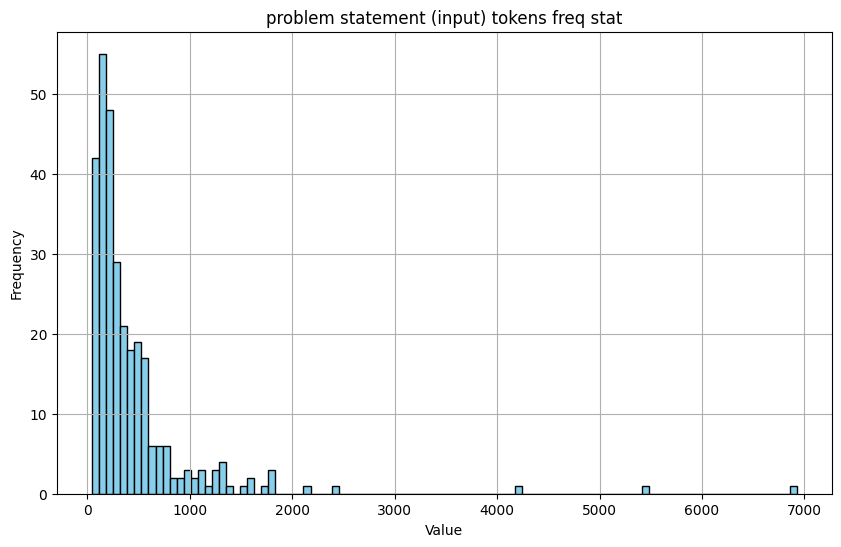

In [94]:
import numpy as np

def plot_histogram_by_bins(data, bins=10, title="Frequency Distribution Histogram", xlabel="Value", ylabel="Frequency"):
    """
    绘制频数分布直方图
    :param data: 数据列表
    :param bins: 直方图的柱数
    :param title: 图表标题
    :param xlabel: x轴标签
    :param ylabel: y轴标签
    """
    # 计算频数和箱边界
    frequencies, bin_edges = np.histogram(data, bins=bins)
    
    # 计算每个箱的中心点
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, frequencies, width=bin_edges[1] - bin_edges[0], color='skyblue', edgecolor='black')
    
    # 添加标题和标签
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)  # 添加网格线
    
# def count_lines_in_patches(patch_str: str):
#     file_changes = []
#     current_file = None
#     lines_added = 0
#     lines_deleted = 0

#     for line in patch_str.split('\n'):
#         # 识别文件变更部分的开始
#         match = re.match(r'^diff --git a/.+ b/(.+)', line)
#         if match:
#             # 如果有正在处理的文件，将其变更统计添加到结果列表中
#             if current_file is not None:
#                 file_changes.append((current_file, lines_deleted, lines_added))
#             # 更新当前文件和行变更计数器
#             current_file = match.group(1)
#             lines_added = 0
#             lines_deleted = 0
#         # 统计添加的行
#         elif line.startswith('+') and not line.startswith('+++'):
#             lines_added += 1
#         # 统计删除的行
#         elif line.startswith('-') and not line.startswith('---'):
#             lines_deleted += 1
    
#     # 处理最后一个文件
#     if current_file is not None:
#         file_changes.append((current_file, lines_deleted, lines_added))
    
#     return file_changes

import tiktoken

def count_tokens(text: str, model_name: str = 'gpt-4o') -> int:
    # 根据模型名称获取编码器
    encoding = tiktoken.encoding_for_model(model_name)
    
    # 编码字符串并返回 token 数量
    tokens = encoding.encode(text)
    return len(tokens)


def describe_tokens(target_ds):
    patch_tokens = []
    statement_tokens = []
    
    for dct in target_ds:
        patch = dct['patch']
        patch_tokens.append(count_tokens(patch))
        statement = dct['problem_statement']
        statement_tokens.append(count_tokens(statement))
        
    plot_histogram_by_bins(patch_tokens, 10, 'patch (output) tokens freq stat')
    plot_histogram_by_bins(statement_tokens, 100, 'problem statement (input) tokens freq stat')


describe_tokens(ds['dev'])
describe_tokens(ds['test'])

In general, input tokens >= 4k, output tokens >= 1k can handle 99% instances

# Describe the level of modified files

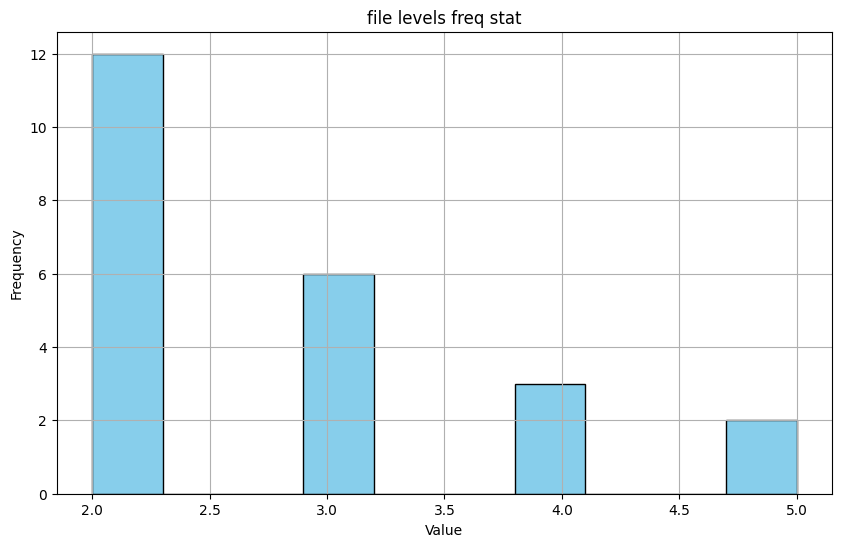

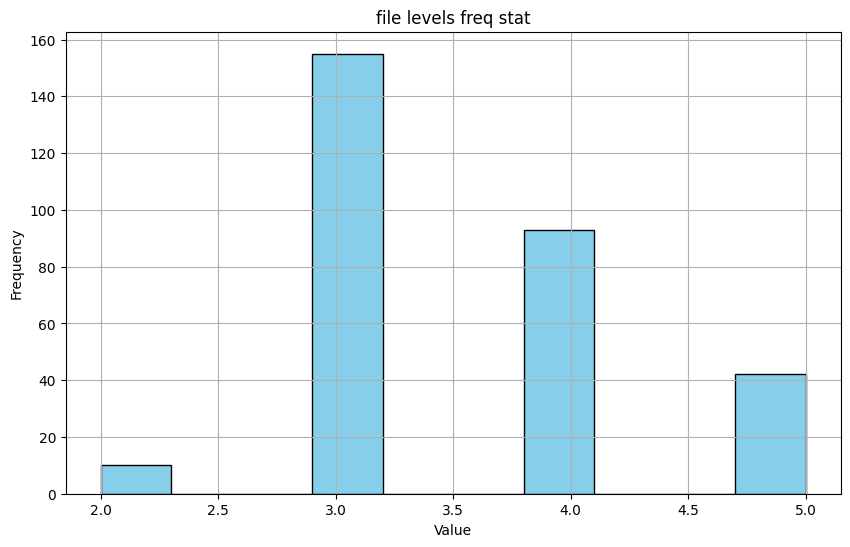

In [105]:
def get_file_level(patch_str: str):
    # 使用正则表达式匹配以 'diff --git' 开头的行
    pattern = re.compile(r'^diff --git a/.+ b/(.+)', re.MULTILINE)
    matches = pattern.findall(patch_str)
    
    # 统计每种类型文件的修改次数
    levels = []
    for match in matches:
        sub_path = match.split('/')
        levels.append(len(sub_path))
    
    # 返回Python文件的修改次数和其他文件的统计信息
    return levels


def describe_level_of_patches(target_ds):
    file_levels = []
    
    for dct in target_ds:
        patch = dct['patch']
        file_levels += get_file_level(patch)

    # print(file_levels)
    plot_histogram_by_bins(file_levels, 10, 'file levels freq stat')

describe_level_of_patches(ds['dev'])
describe_level_of_patches(ds['test'])

In gereneral, the level of modified files are range from 2 to 5


# Opponent stat in SWEBench-lite (2024-07-23)

CodeStory Aide Mixed (%44, 132 / 300)

![image1](./imgs/mixed-model-in-lite.png)


AbanteAI MentatBot GPT-4o (39%, 117 / 300)

![image2](./imgs/AbanteAI-MentatBot.png)


Lingma Agent (33%, 100 / 300)

![image3](./imgs/lingma-agent.png)